In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [173]:
# Get calibration points of all images and return them, also
# return the image shape
def getCalibration(pathToImages, kernel=(9, 6), plot=0):

    objpoints = []
    imgpoints = []
    
    nx = kernel[0]
    ny = kernel[1]

    objp       = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    images = glob.glob(pathToImages + '*.jpg')

    for idx, fname in enumerate(images):
        image = cv2.imread(fname)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            img = cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
            if plot:
                f, (p1) = plt.subplots(1,1, figsize=(5,5))
                f.tight_layout() 
                p1.set_title('Original: ' + fname)
                p1.imshow(img)
                p1.axis('off')
                plt.show()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera( objpoints, 
                                                        imgpoints, 
                                                        gray.shape[::-1], 
                                                        None, 
                                                        None)
    
    return mtx, dist

In [ ]:
# Get calibration for camera
mtx, dist = getCalibration('camera_cal/calibration', (9, 6), 1);

In [169]:
def plotUndistorted(pathToImages, mtx, dist):
    
    images = glob.glob(pathToImages + '*.jpg')
    nimgs = len(images)

    for idx, fname in enumerate(images):
        
        f, (p1, p2) = plt.subplots(1,2, figsize=(10,5))
        f.tight_layout() 
    
        image = cv2.imread(fname)
        undist = cv2.undistort(image, mtx, dist, None, mtx)
        undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        p1.set_title('Original: ' + fname)
        p1.imshow(image)
        p1.axis('off')
        p2.set_title('Undistorted: ' + fname)
        p2.imshow(undist)
        p2.axis('off')
    
        plt.show()

In [ ]:
plotUndistorted('camera_cal/calibration', mtx, dist)

In [178]:
def getGridAreas(pathToImages, mtx, dist, kernel=(9, 6)):
    
    nx = kernel[0]
    ny = kernel[1]

    images = glob.glob(pathToImages + '*.jpg')

    for idx, fname in enumerate(images):
        image = cv2.imread(fname)
        undist = cv2.undistort(image, mtx, dist, None, mtx)
        gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True:
            # Draw and display the corners
            cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
            offset = 100
            img_size = (gray.shape[1], gray.shape[0])
            src = np.float32([corners[0], 
                              corners[nx-1], 
                              corners[-1], 
                              corners[-nx]])
            dst = np.float32([[offset, offset], 
                              [img_size[0]-offset, offset], 
                              [img_size[0]-offset, img_size[1]-offset], 
                              [offset, img_size[1]-offset]])
            M = cv2.getPerspectiveTransform(src, dst)
            warped = cv2.warpPerspective(undist, M, img_size)

            f, (p1, p2) = plt.subplots(1,2, figsize=(10,5))
            f.tight_layout() 

            image = cv2.imread(fname)
            undist = cv2.undistort(image, mtx, dist, None, mtx)
            undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            p1.set_title('Original: ' + fname)
            p1.imshow(image)
            p1.axis('off')
            p2.set_title('Grid: ' + fname)
            p2.imshow(warped)
            p2.axis('off')

            plt.show()

In [ ]:
getGridAreas('camera_cal/calibration', mtx, dist, (9,6))

In [606]:
# Define all used color spaces
def colorSpace(image, color):
    if color == 'bgr_r':
        return image[:,:,2]
    if color == 'bgr_g':
        return image[:,:,1]
    if color == 'bgr_b':
        return image[:,:,0]
    if color == 'hls_s':
        hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        return hls[:,:,2]
    if color == 'yuv_y':
        yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        return yuv[:,:,0]
    if color == 'gray':
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if color == 'lab_b':
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
        return lab[:,:,2]
    if color == 'yuv_u':
        yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        return yuv[:,:,1]
    if color == 'hls_h':
        hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        return hls[:,:,0]
    return None

In [607]:
# Combine sobel stuff
def sobel_detect(img, sobel_kernel=3, dir_thresh=(0, np.pi/2, np.pi/6), abs_thresh=(10, 255), mag_thresh=(0, 255)):
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    mag_sobel_manhattan = np.uint8( 255 * ( np.abs(sobelx) + np.abs(sobely) ) / np.max( np.abs(sobelx) + np.abs(sobely) ) )
    mag_sobel_euclidean = np.uint8( 255 * np.sqrt(sobelx**2 + sobely**2)/np.max(np.sqrt(sobelx**2 + sobely**2))) 
    
    binary_output = np.zeros_like(absgraddir)
    
    # Do note that we compare angles
    # Then magnitude of sobel vector as euclidean
    # Then magnitude of sobel vector as manhattan
    binary_output[ ( ( (absgraddir >= dir_thresh[0] - dir_thresh[2]) & (absgraddir <= dir_thresh[0] + dir_thresh[2]) ) |
                     ( (absgraddir >= dir_thresh[1] - dir_thresh[2]) & (absgraddir <= dir_thresh[1] + dir_thresh[2]) ) ) & 
                     ( (mag_sobel_euclidean >= mag_thresh[0]) & (mag_sobel_euclidean <= mag_thresh[1]) ) & 
                     ( (mag_sobel_manhattan >= abs_thresh[0]) & (mag_sobel_manhattan <= abs_thresh[1]) ) ] = 1
    
    return binary_output

In [608]:
def range_select(img, thresh=(0, 255)):
    
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
    
    return binary_output

In [1841]:
def normalize_channel(image_data):
    image_data = np.array(image_data)
    x_min = (image_data.min())
    x_max = (image_data.max())
    # Non extreme values are useful to avoid saturation
    a     = 0
    b     = 255
    return a + ( b - a ) * np.true_divide( ( image_data - x_min ),  ( x_max - x_min + 0.0001) ) 

In [1911]:
def preprocess_image(image):
    img   = cv2.cvtColor(image, cv2.COLOR_BGR2HLS);
    a,b,c = cv2.split(img)
    # I hand tuned these myself
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
    #y     = clahe.apply(y)
    b     = 127 * np.ones_like(b)
    abc   = cv2.merge((a,b,c))
    rgb   = cv2.cvtColor(abc, cv2.COLOR_HLS2BGR);
    rgb[:,:,:] = normalize_channel(rgb[:,:,:])
    # normalize channels then
    #rgb[:,:,0] = normalize_channel(rgb[:,:,0])
    #rgb[:,:,1] = normalize_channel(rgb[:,:,1])
    #rgb[:,:,2] = normalize_channel(rgb[:,:,2])
    return rgb

In [1919]:
def pipeline(img, plot_masks=0):
    
    # undistort image
    image = cv2.undistort(img, mtx, dist, None, mtx)
    #image = preprocess_image(image)
    
    combined = np.zeros_like(image[:,:,0])
    
    rangedr = (range_select(colorSpace(image, 'bgr_r'), thresh=(120, 255)))
    sobelr  = (sobel_detect(colorSpace(image, 'bgr_r'), sobel_kernel=5, dir_thresh=(0.78,2.35,np.pi/6), abs_thresh=(70,255), mag_thresh=(80,255)))
    
    rangeds = (range_select(colorSpace(image, 'hls_s'), thresh=(80, 255)))
    sobels  = (sobel_detect(colorSpace(image, 'hls_s'), sobel_kernel=5, dir_thresh=(0.78,2.35,np.pi/6), abs_thresh=(50,255), mag_thresh=(50,255)))   
    
    rangedur = (range_select(colorSpace(image, 'bgr_r'), thresh=(225, 255)))
    sobelur  = (sobel_detect(colorSpace(image, 'bgr_r'), sobel_kernel=5, dir_thresh=(0.78,2.35,np.pi/5), abs_thresh=(5,255), mag_thresh=(5,255)))
    
    combined = np.zeros_like(image[:,:,0])
    combined[ ((rangedur >= 1) & (sobelur >= 1)) | ((rangedr >= 1) & (sobelr >= 1)) | ((rangeds >= 1) & (sobels >= 1)) ] = 1
    
    # prune all points not red or green enough (bc white)
    filterr = (range_select(colorSpace(image, 'bgr_r'), thresh=(110, 255)))
    filterg = (range_select(colorSpace(image, 'bgr_g'), thresh=(110, 255)))
    combined[ (filterr == 0) | (filterg == 0) ] = 0 
    
    if plot_masks:
        maskr = np.zeros_like(image[:,:,0])
        maskr[((rangedr >= 1) & (sobelr >= 1))] = 1
        masks = np.zeros_like(image[:,:,0])
        masks[((rangeds >= 1) & (sobels >= 1))] = 1
        maskur = np.zeros_like(image[:,:,0])
        maskur[((rangedur >= 1) & (sobelur >= 1))] = 1
        maskf = np.zeros_like(image[:,:,0])
        maskf[((filterr >= 1) & (filterg >= 1))] = 1
    
        f, (p1, p2, p3, p4, p5, p6) = plt.subplots(1,6, figsize=(60,10))
        f.tight_layout() 
        p1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        p2.imshow(maskr, cmap = 'gray')
        p3.imshow(masks, cmap = 'gray')
        p4.imshow(maskur, cmap = 'gray')
        p5.imshow(maskf, cmap = 'gray')
        p6.imshow(combined, cmap = 'gray')
        plt.show()

    return combined

In [ ]:
def appyPipeline(pathToImages, pipeline):

    images = glob.glob(pathToImages + '*.jpg')

    for idx, fname in enumerate(images):
        image = cv2.imread(fname)
        procimg = pipeline(image, 1)
        
appyPipeline('test_images/', pipeline)

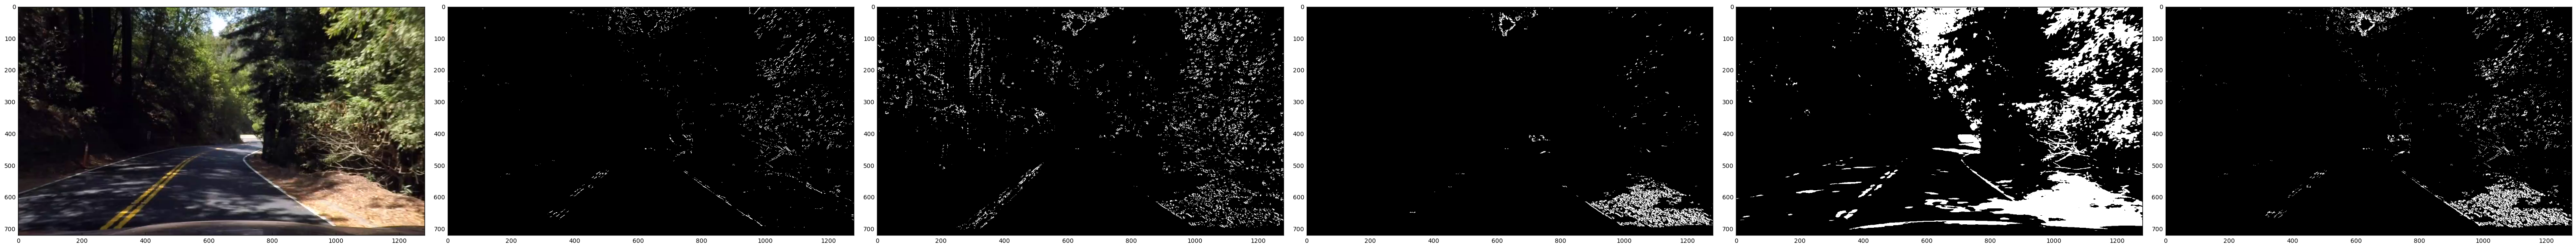

In [1921]:
vidcap = cv2.VideoCapture('harder_challenge_video.mp4')
success,image = vidcap.read()
count = 0
success = True

for i in range(300):
    success,image = vidcap.read()
    count += 1
    
procimg = pipeline(image, 1)

In [1882]:
def transform(image, erode=1):
    
    img_size = (image.shape[1], image.shape[0])
    offset = 300
    
    tolerance = 0.04
    
    src = np.float32([[img_size[0] * ( 0.5 - tolerance ), img_size[1] * 0.625], 
                      [img_size[0] * ( 0.5 + tolerance ), img_size[1] * 0.625], 
                      [img_size[0] * 0.9,  img_size[1]], 
                      [img_size[0] * 0.1,  img_size[1]]])
    
    dst = np.float32([[offset, 0], 
                      [img_size[0] - offset, 0], 
                      [img_size[0] - offset, img_size[1]], 
                      [offset, img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src) 
                       
    warped = cv2.warpPerspective(image, M, img_size)
    
    if erode:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
        erosion = cv2.erode(warped,kernel,iterations = 1)
        dilation = cv2.dilate(erosion, kernel, iterations = 1)
        resized = cv2.resize(dilation, (0,0), fx=1/4, fy=8/4, interpolation=cv2.INTER_AREA )  
    else:
        resized = cv2.resize(warped, (0,0), fx=1/4, fy=8/4, interpolation=cv2.INTER_AREA )  
    
    saturated = np.zeros_like(resized)
    saturated[resized > 0] = 1
                           
    return saturated, M, Minv

In [1657]:
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# Obtain clusters of pixels in image section and return them
# along with how many points were classified into clusters

def clusterizeSection(img, pxradius=20):
    idxy, idxx = np.nonzero(img)
    conv = [ [idxx[j], idxy[j]] for j in range(len(idxy)) ]
    
    means = []
    weights = []
    
    if (len(conv)) > 0:
        X = np.array(conv) #StandardScaler().fit_transform(conv)
        db = DBSCAN(eps=pxradius, min_samples=10).fit(X)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        unique_labels = set(labels)
        
        for k in unique_labels:
            class_member_mask = (labels == k)
            #xy = X[class_member_mask & core_samples_mask]
            xy = X[class_member_mask]
            if len(xy) > 0:
                means.append(xy.mean(axis=0))
                weights.append(len(xy))
            else:
                n_clusters_ = n_clusters_ - 1
            
        if (n_clusters_ > 0) and (len(means) > 0):
            return n_clusters_, means, weights
        
    return 0, None, None

In [1658]:
def getPointBlobs(warped, slices=10, pxradius=20, scalef=1):
    all_means = []
    all_weights = []
        
    for i in range(slices * 2 - 1):
        step = warped.shape[0]//slices
        end = warped.shape[0] - i * (step//2)
        start = end - step

        section = warped[start:end,:]
        histogram = np.sum(section[:,:], axis=0)
        
        n_clusters, means, weights = clusterizeSection(section, pxradius)
        
        if n_clusters > 0:
            traslated_means = []
            for mean in means:
                traslated_means.append([scalef * mean[0], scalef * ( warped.shape[0] - ( start  + mean[1] ))])
            all_means.append(traslated_means)
            all_weights.append(weights)

    return all_means, all_weights

In [1659]:
def clusterizeLanesAll(means, weights, pxtolerance=40, scalef=1):
    # clusterize upwards
    labels   = []
    labels_w = []
    # point labels should have len of points
    points_labels = []
    points_values = []
    
    flat_means = [mean for elements in means for mean in elements]
    flat_means = np.array(flat_means)
    flat_means = flat_means[flat_means[:,1].argsort()]
    
    for mean in flat_means:
        # look for correspondance, if not, add as new label
        meanx = mean[0]
        meany = mean[1]
        label = -1
        # look for min distance in X to topmost point
        if len(labels) > 0:
            alls = np.array(points_values)
            labs = np.array(points_labels)
            allsx = alls[:,0]
            allsy = alls[:,1]
            allsx = allsx - meanx
            allsy = allsy - meany
            # Get x points in range
            allsxabs = np.abs(allsx)
            candidatespx = allsx[allsxabs < pxtolerance * scalef]
            candidatespy = allsy[allsxabs < pxtolerance * scalef]
            candidatesl  =  labs[allsxabs < pxtolerance * scalef]
            # Get topmost points for each one
            if len(candidatesl) > 0:
                # Get closest point in candidates, increase x distance thogh by
                # some empirical amount, to favor closeness in Y
                allsxy = np.sqrt((8 * candidatespx)**2 + (1 * candidatespy)**2)
                idx    = np.argmin(allsxy)
                # Check if there is closer point of label in Y
                # that breaks tolerance
                label = candidatesl[idx]
        # if no match is found assume new label
        if label == -1:
            label = len(labels)
            labels.append(label)
            labels_w.append(0)
        # assign label to point
        points_labels.append(label)
        points_values.append([meanx, meany])
        labels_w[label] = labels_w[label] + 1
    
    labels = np.array(labels)
    points_labels = np.array(points_labels)
    points_values = np.array(points_values)
    labels_w = np.array(labels_w)
    
    return labels, points_labels, points_values, labels_w

In [1660]:
def clusterizeLanesTop(means, weights, pxtolerance=40, scalef=1):
    # clusterize upwards
    labels = []
    topmost = []
    labels_w = []
    # point labels should have len of points
    points_labels = []
    points_values = []
    
    flat_means = [mean for elements in means for mean in elements]
    flat_means = np.array(flat_means)
    flat_means = flat_means[flat_means[:,1].argsort()]
    
    for mean in flat_means:
        
        # look for correspondance, if not, add as new label
        meanx = mean[0]
        meany = mean[1]
        label = -1
        # look for min distance in X to topmost point
        if len(topmost) > 0:
            tops = np.array(topmost)
            topsx = tops[:,0]
            topsx = topsx - meanx
            topsx = np.abs(topsx)
            topsy = tops[:,1]
            topsy = topsy - meany
            topsy = np.abs(topsy)
            # get mins
            candidate_idx = topsx.argsort()[:]
            topsx         = np.sort(topsx) 
            topsy         = topsy[candidate_idx]
            # best in Y
            candidate_idx = candidate_idx[np.abs(topsx) <= pxtolerance * scalef]
            ctopsx        =         topsx[np.abs(topsx) <= pxtolerance * scalef]
            ctopsy        =         topsy[np.abs(topsx) <= pxtolerance * scalef]
            if len(candidate_idx) > 0:
                # try euclid
                ctopsxy = np.sqrt((8 * ctopsx)**2 + (1 * ctopsy)**2)
                idy = np.argmin(ctopsxy)
                idx = candidate_idx[idy]
                label = idx
                # if point is higher in Y update topmost
                if meany > topmost[idx][1]:
                    topmost[idx][0] = meanx
                    topmost[idx][1] = meany
        # if no match is found assume new label
        if label == -1:
            label = len(labels)
            labels.append(label)
            labels_w.append(0)
            topmost.append(mean)
        # assign label to point
        points_labels.append(label)
        points_values.append([meanx, meany])
        labels_w[label] = labels_w[label] + 1
    
    labels = np.array(labels)
    points_labels = np.array(points_labels)
    points_values = np.array(points_values[:])
    labels_w = np.array(labels_w)
    
    return labels, points_labels, points_values, labels_w

In [1661]:
def getLaneClusters(warped, order=5, closetol=20, longtol=30, scalef=0.025, plot=0, top=1):
    means,weights = getPointBlobs(warped, order, closetol, scalef);
    
    if top:
        labels, points_labels, points_values, labels_w = clusterizeLanesTop(means, weights, longtol, scalef);
    else:
        labels, points_labels, points_values, labels_w = clusterizeLanesAll(means, weights, longtol, scalef);

    if plot:
        unique_labels = set(labels)
        colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = 'k'

            class_member_mask = (points_labels == k)

            xy = points_values[class_member_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                     markeredgecolor='k', markersize=14)
        plt.show()
        
    return labels, points_labels, points_values, labels_w

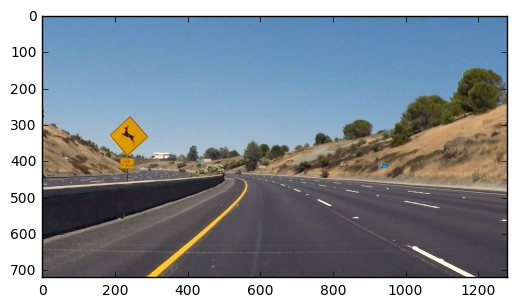

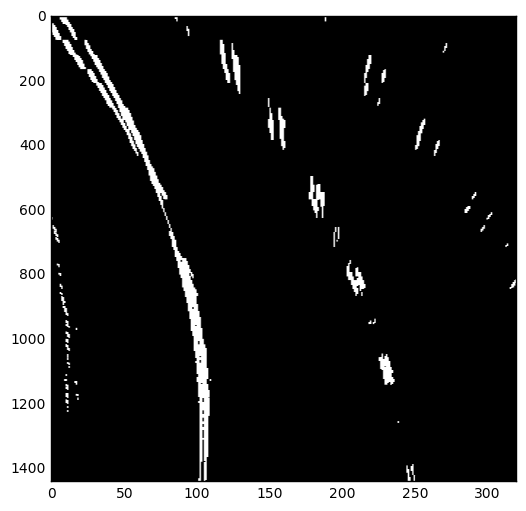

C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


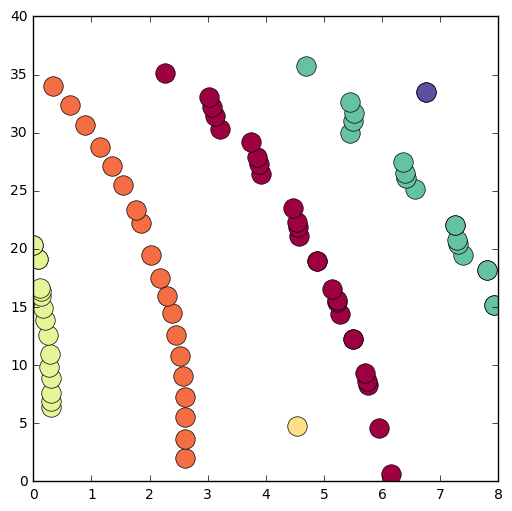

C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


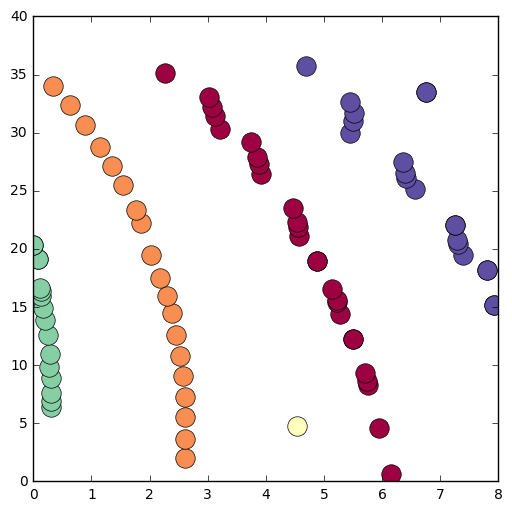

In [1662]:
image = cv2.imread('test_images/test2.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

procimg = pipeline(image)
warped, M, Minv  = transform(procimg, erode=1)
plt.figure(figsize=(6,6))
plt.imshow(warped, cmap='gray', aspect='auto')
plt.show()

plt.figure(figsize=(6,6))
l,pl,ps,lw = getLaneClusters(warped, 10, 20, 40, 0.025, plot=1, top=1)
plt.figure(figsize=(6,6))
l,pl,ps,lw = getLaneClusters(warped, 10, 20, 40, 0.025, plot=1, top=0)

In [1564]:
def getFits(labels, points_labels, points_values, labels_weights, plot=0):
    colors = plt.cm.Spectral(np.linspace(0, 1, len(labels)))
    # Apply fit to found points (more than 8!)
    fits   = []
    curvs  = []
    labs   = []
    for k in labels:
        if (labels_weights[k]) > 8:
            points = points_values[points_labels == k]
            xvals = points[:,0]
            yvals = points[:,1]
            p_fit = np.polyfit(yvals, xvals, 2)
            y_eval = np.min(yvals)
            p_curverad = ((1 + (2*p_fit[0]*y_eval + p_fit[1])**2)**1.5)/np.absolute(2*p_fit[0])
            fits.append(p_fit)
            curvs.append(p_curverad)
            labs.append(k)
            if plot:
                p_fitx = p_fit[0]*yvals**2 + p_fit[1]*yvals + p_fit[2]
                plt.plot(p_fitx, yvals, 'o', color=colors[k], linewidth=3)
    if plot:
        plt.show()
        
    return labels, fits, curvs

C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


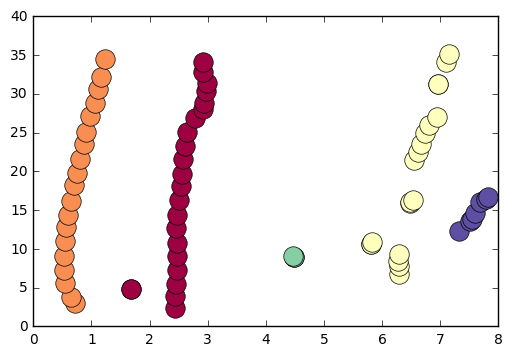

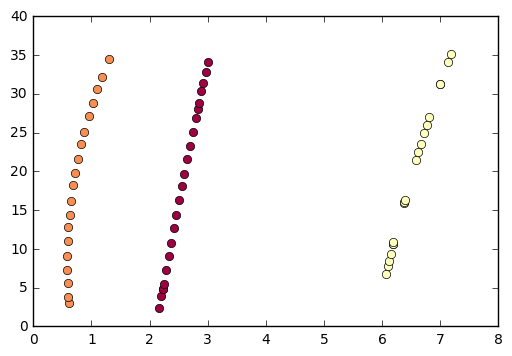

In [1581]:
image = cv2.imread('test_images/test4.jpg')
procimg = pipeline(image)
warped = transform(procimg)
labels,points_labels,points_values,labels_weights = getLaneClusters(warped, 10, 20, 40, 0.025, plot=1, top=1)
labels,fits,curvs = getFits(labels, points_labels, points_values, labels_weights, plot=1)

In [1650]:
#extract left and right fits withi possible range of car
def getSidedFits(image, fits, tol=2*3.7, scalef=0.025, plot=0):
    zerox = 0.5 * scalef * image.shape[1] / 4
    
    fit0x = []
    for k in range(len(fits)):
        fit = fits[k]
        fit0x.append(fit[2])

    # find closest fits to car
    fit0xnp = np.array(fit0x)
    caroffset = fit0xnp - zerox
    caroffset = np.abs(caroffset)
    minidx = caroffset.argsort()[:]

    # classify fits as feasible or not
    left_fits = []
    right_fits = []
    for k in range(len(fits)):
        idx = minidx[k]
        if caroffset[idx] < tol:
            if fits[idx][2] > zerox:
                right_fits.append(fits[idx])
            if fits[idx][2] < zerox:
                left_fits.append(fits[idx])
    
    if plot:
        for l_fit in right_fits:
            l_fity = np.arange(0, 8 * scalef * image.shape[0] / 4, 1)
            l_fitx = l_fit[0]*l_fity**2 + l_fit[1]*l_fity + l_fit[2]
            plt.plot(l_fitx, l_fity, 'o')
        for l_fit in left_fits:
            l_fity = np.arange(0, 8 * scalef * image.shape[0] / 4, 1)
            l_fitx = l_fit[0]*l_fity**2 + l_fit[1]*l_fity + l_fit[2]
            plt.plot(l_fitx, l_fity, 'x')
        plt.show()
        
    return left_fits, right_fits

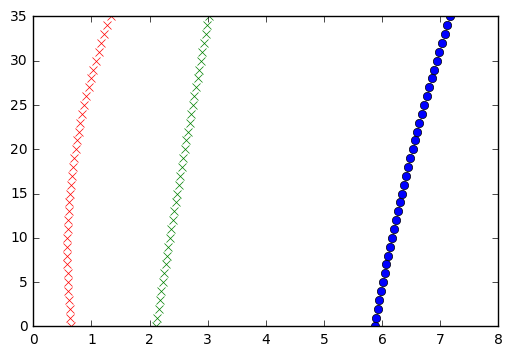

In [1651]:
# Use found fits as basis for EM algo

image = cv2.imread('test_images/test1.jpg')
procimg = pipeline(image)
warped = transform(procimg, 0)

def optimFitEM(warped, fits, x_tol=0.5, scalef=0.025, plot=1):
    # Get ALL points of image
    idxy, idxx = np.nonzero(warped)

    # See if they are within fit and use for optim
    xvals = scalef * idxx[:]
    yvals = scalef * ( warped.shape[0] - idxy[:] )
    improved_fits = []
    curvs = []
    
    for fit in fits:
        # 3 iterations seems enought though
        sfit = fit
        for i in range(4):
            # Get points within range of fit
            # p_fitx = p_fit[0]*yvals**2 + p_fit[1]*yvals + p_fit[2]
            xfit = [ xvals[j] for j in range(len(xvals)) if (abs(sfit[0]*yvals[j]**2 + sfit[1]*yvals[j] + sfit[2] - xvals[j]) < x_tol) ]
            yfit = [ yvals[j] for j in range(len(xvals)) if (abs(sfit[0]*yvals[j]**2 + sfit[1]*yvals[j] + sfit[2] - xvals[j]) < x_tol) ]
            pxvals = np.array(xfit)
            pyvals = np.array(yfit)
            sfit = np.polyfit(pyvals, pxvals, 2)
        y_eval = np.min(pyvals)
        curv = ((1 + (2*sfit[0]*y_eval + sfit[1])**2)**1.5)/np.absolute(2*sfit[0])
        improved_fits.append(sfit)
        curvs.append(curv)

    if plot:
        print(improved_fits)
        print(curvs)
        for l_fit in improved_fits:
            l_fity = np.arange(0, 8 * scalef * image.shape[0] / 4, 1)
            l_fitx = l_fit[0]*l_fity**2 + l_fit[1]*l_fity + l_fit[2]
            plt.plot(l_fitx, l_fity, 'o')
        plt.show()
        
    return improved_fits, curvs

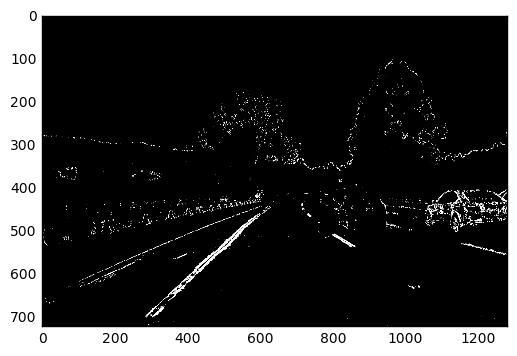

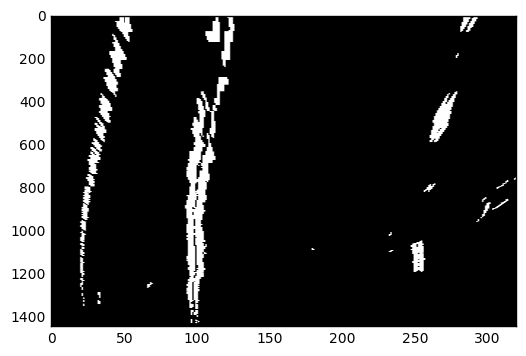

C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


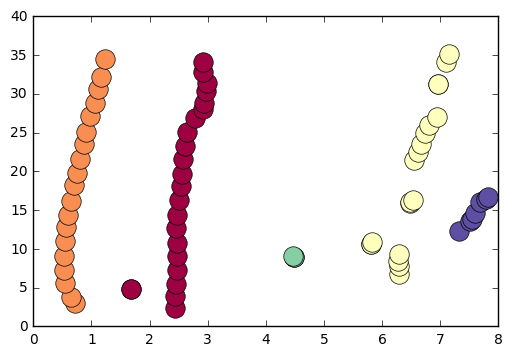

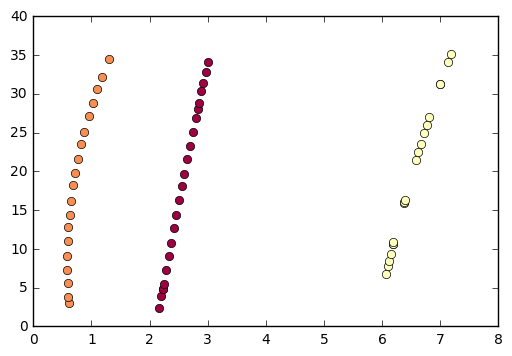

[array([  6.59008913e-04,  -8.38671404e-03,   2.47430018e+00]), array([ 0.00068904, -0.00270679,  0.53010572]), array([  5.74031223e-04,   8.03427894e-03,   6.17380822e+00])]
[758.78716158735392, 725.64591836294426, 871.33616822951478]


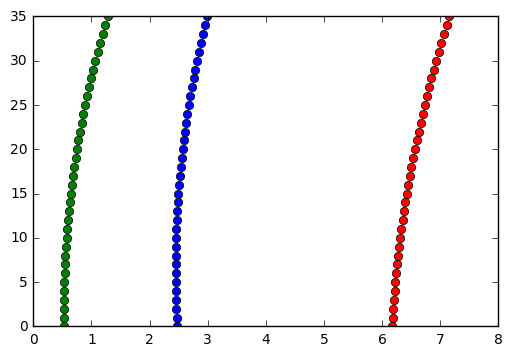

In [1672]:
image = cv2.imread('test_images/test4.jpg')
procimg = pipeline(image)
plt.imshow(procimg, cmap='gray', aspect='auto')
plt.show()
warped,_,_ = transform(procimg)
plt.imshow(warped, cmap='gray', aspect='auto')
plt.show()
labels,points_labels,points_values,labels_weights = getLaneClusters(warped, 10, 20, 40, 0.025, plot=1, top=1)
labels,fits,curvs = getFits(labels, points_labels, points_values, labels_weights, plot=1)
fits,curvs = optimFitEM(warped, fits, x_tol=0.6, scalef=0.025, plot=1);

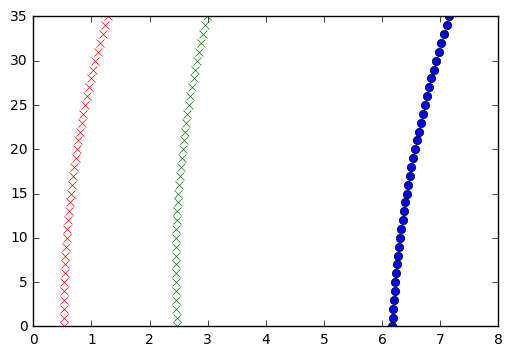

In [1655]:
left_fits, right_fits = getSidedFits(image, fits, tol=3.7, scalef=0.025, plot=1)

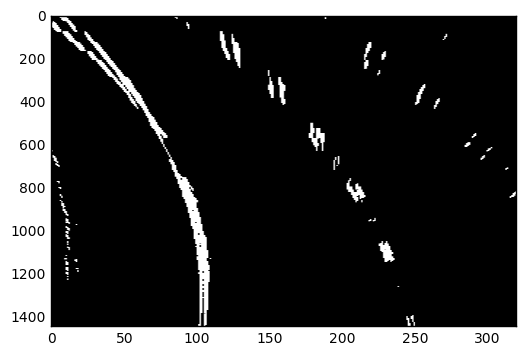

(720, 1280)
(720, 1280, 3)


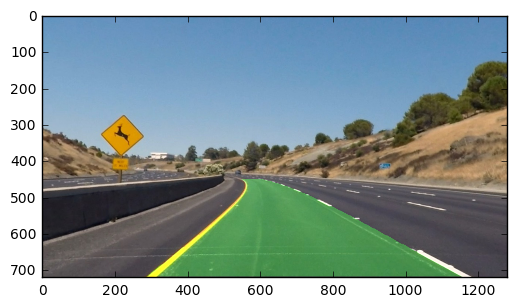

In [1708]:
# plot the fits into image, use only immediate sides though
image = cv2.imread('test_images/test2.jpg')
procimg = pipeline(image)
image = cv2.undistort(image, mtx, dist, None, mtx)

warped,M,Minv = transform(procimg)
plt.imshow(warped, cmap='gray', aspect='auto')
plt.show()

labels,points_labels,points_values,labels_weights = getLaneClusters(warped, 10, 20, 40, 0.025, plot=0, top=1)
labels,fits,curvs = getFits(labels, points_labels, points_values, labels_weights, plot=0)
fits,curvs = optimFitEM(warped, fits, x_tol=0.6, scalef=0.025, plot=0);
left_fits, right_fits = getSidedFits(image, fits, tol=3.7, scalef=0.025, plot=0)

warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

scalef = 0.025

l_fit = left_fits[0]
l_fity = (1) * np.arange(0, 8 * scalef * image.shape[0] / 4, 1)
l_fitx = l_fit[0]*l_fity**2 + l_fit[1]*l_fity + l_fit[2]
l_fity = (8 / (8 * scalef)) * l_fity
l_fitx = (8 / (8 * scalef)) * l_fitx

r_fit = right_fits[0]
r_fity = (1) * np.arange(0, 8 * scalef * image.shape[0] / 4, 1)
r_fitx = r_fit[0]*r_fity**2 + r_fit[1]*r_fity + r_fit[2]
r_fity = (8 / (8 * scalef)) * r_fity
r_fitx = (8 / (8 * scalef)) * r_fitx

#plt.plot(l_fitx, 2*image.shape[0]-l_fity)
#plt.plot(r_fitx, 2*image.shape[0]-r_fity)
#plt.show()

l_fity=2*image.shape[0]-l_fity
r_fity=2*image.shape[0]-r_fity

pts_left = np.array([np.transpose(np.vstack([l_fitx, l_fity]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([r_fitx, r_fity])))])

pts = np.hstack((pts_left, pts_right))
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

#plt.imshow(color_warp)
#plt.show()

color_warp = cv2.resize(color_warp, (0,0), fx=4, fy=1/2, interpolation=cv2.INTER_AREA )

#plt.imshow(color_warp)
#plt.show()

newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

#plt.imshow(newwarp)
#plt.show()

print(procimg.shape)
print(newwarp.shape)

result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

In [1874]:
vidcap = cv2.VideoCapture('harder_challenge_video.mp4')
success,image = vidcap.read()
count = 0
success = True

for i in range(100):
    success,image = vidcap.read()
    count += 1

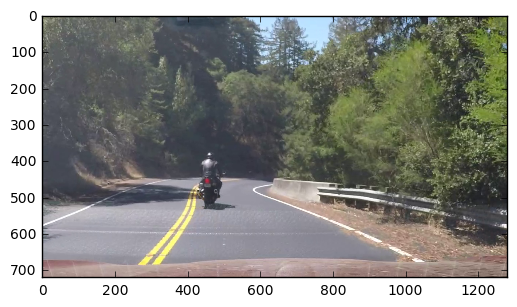

In [1875]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

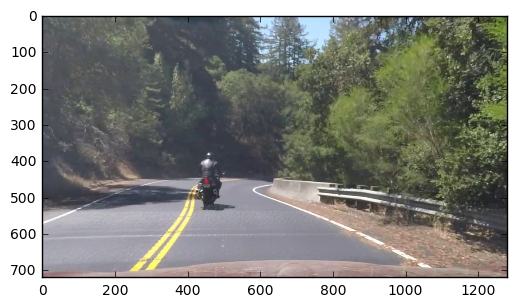

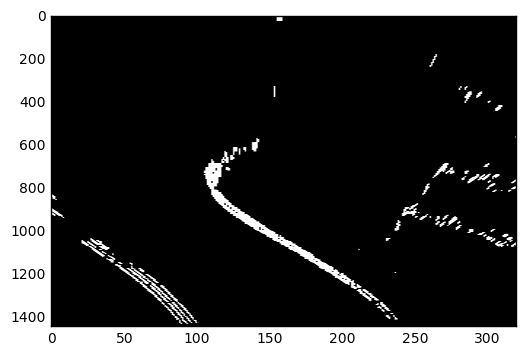

(720, 1280)
(720, 1280, 3)


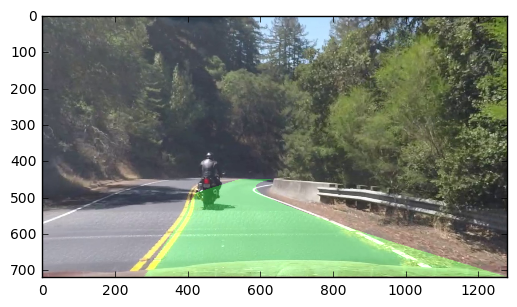

In [1876]:
procimg = pipeline(image)
image = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

warped,M,Minv = transform(procimg)
plt.imshow(warped, cmap='gray', aspect='auto')
plt.show()

labels,points_labels,points_values,labels_weights = getLaneClusters(warped, 10, 20, 40, 0.025, plot=0, top=1)
labels,fits,curvs = getFits(labels, points_labels, points_values, labels_weights, plot=0)
fits,curvs = optimFitEM(warped, fits, x_tol=0.6, scalef=0.025, plot=0);
left_fits, right_fits = getSidedFits(image, fits, tol=3.7, scalef=0.025, plot=0)

warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

scalef = 0.025

l_fit = left_fits[0]
l_fity = (1) * np.arange(0, 8 * scalef * image.shape[0] / 4, 1)
l_fitx = l_fit[0]*l_fity**2 + l_fit[1]*l_fity + l_fit[2]
l_fity = (8 / (8 * scalef)) * l_fity
l_fitx = (8 / (8 * scalef)) * l_fitx

r_fit = right_fits[0]
r_fity = (1) * np.arange(0, 8 * scalef * image.shape[0] / 4, 1)
r_fitx = r_fit[0]*r_fity**2 + r_fit[1]*r_fity + r_fit[2]
r_fity = (8 / (8 * scalef)) * r_fity
r_fitx = (8 / (8 * scalef)) * r_fitx

#plt.plot(l_fitx, 2*image.shape[0]-l_fity)
#plt.plot(r_fitx, 2*image.shape[0]-r_fity)
#plt.show()

l_fity=2*image.shape[0]-l_fity
r_fity=2*image.shape[0]-r_fity

pts_left = np.array([np.transpose(np.vstack([l_fitx, l_fity]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([r_fitx, r_fity])))])

pts = np.hstack((pts_left, pts_right))
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

#plt.imshow(color_warp)
#plt.show()

color_warp = cv2.resize(color_warp, (0,0), fx=4, fy=1/2, interpolation=cv2.INTER_AREA )

#plt.imshow(color_warp)
#plt.show()

newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

#plt.imshow(newwarp)
#plt.show()

print(procimg.shape)
print(newwarp.shape)

result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()